# House Price Prediction Comparison

This notebook implements three versions of a neural network to predict house prices using Keras/TensorFlow, PyTorch, and JAX (Flax/Optax). In all cases:

- The target (`SalePrice`) is log-transformed during training to stabilize the dynamic range. Predictions are exponentiated before RMSE is computed.
- Feature selection is applied based on the correlation matrix (keeping the top five features most correlated with `SalePrice`).
- Data is split (80% train, 20% validation) and scaled via `StandardScaler`.
- The loss is a combined loss: Mean Squared Error (MSE) on the log targets plus a KL divergence penalty computed from differentiable soft histograms. (The KL weight is kept low to avoid numerical issues.)

Predictions are saved to:
  - `predictions_keras_KL.csv`
  - `predictions_pytorch_KL.csv`
  - `predictions_jax_KL.csv`

Summary plots compare loss curves and the predicted vs. actual price distributions (after exponentiation).

In [2]:
pip install pytorch tensorflow jax flax

  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-hqjfqu13/pytorch_efea1aa9e37644ab9c923b5474a78ae7/setup.py", line 15, in <module>
          raise Exception(message)
      Exception: You tried to install "pytorch". The package named for PyTorch is "torch"
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
ERROR: ERROR: Failed to build installable whe

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

# JAX / Flax / Optax
import jax
import jax.numpy as jnp
import flax.linen as nn_flax
from flax.training import train_state
import optax

print('TensorFlow version:', tf.__version__)
print('Torch version:', torch.__version__)
print('JAX version:', jax.__version__)

%matplotlib inline

2025-02-25 10:23:28.045342: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-25 10:23:28.382788: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-25 10:23:28.538917: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740479008.799351    2507 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740479008.908212    2507 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-25 10:23:30.271390: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

TensorFlow version: 2.18.0
Torch version: 2.5.1+cpu
JAX version: 0.5.0


## 1. Load and Preprocess Data

Update the file paths below to point to your `train.csv` and `test.csv` files.

In [4]:
# Update these paths as needed
train_path = 'train.csv'
test_path = 'test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print('Train shape:', train_df.shape)
print('Test shape:', test_df.shape)

Train shape: (1000, 81)
Test shape: (460, 80)


### 1.1 Preprocessing & Target Transformation

Fill missing values (numeric with median, categorical with mode), drop the `Id` column, one-hot encode categorical features, and apply a log transformation to the target (`SalePrice`).

Processed training features shape: (1000, 230)


/tmp/ipykernel_2507/3179406045.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_2507/3179406045.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

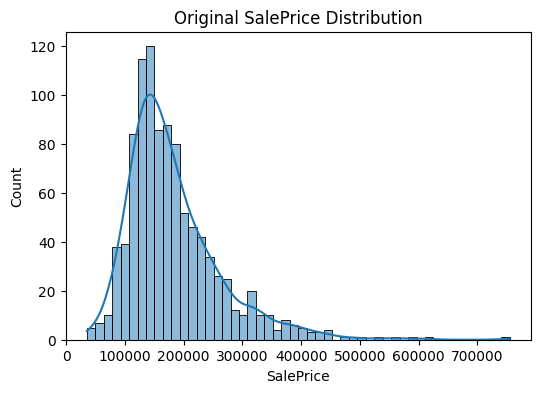

In [5]:
def fill_missing_values(df):
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in num_cols:
        df[col].fillna(df[col].median(), inplace=True)
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)
    return df

# Process training data
train_df = fill_missing_values(train_df.copy())

# Save and drop Id column
train_ids = train_df['Id']
train_df.drop('Id', axis=1, inplace=True)

# Log-transform the target SalePrice
y = np.log(train_df['SalePrice'])
X = train_df.drop('SalePrice', axis=1)

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

print('Processed training features shape:', X.shape)

# Plot original SalePrice distribution
plt.figure(figsize=(6,4))
sns.histplot(np.exp(y), bins=50, kde=True)
plt.title('Original SalePrice Distribution')
plt.xlabel('SalePrice')
plt.show()

### 1.2 Feature Selection

Compute the correlation matrix (using numeric columns) and select the top five features most correlated with `SalePrice`.

In [6]:
numeric_df = train_df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
top_features = corr_matrix['SalePrice'].abs().sort_values(ascending=False).iloc[1:6].index.tolist()
print('Top 5 features selected:', top_features)

# Restrict X to these features
X = X[top_features]
print('X shape after feature selection:', X.shape)

Top 5 features selected: ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF']
X shape after feature selection: (1000, 5)


### 1.3 Train-Validation Split and Scaling

Split the data (80% train, 20% validation) and scale features using `StandardScaler`.

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print('X_train_scaled shape:', X_train_scaled.shape)
print('X_val_scaled shape:', X_val_scaled.shape)

X_train_scaled shape: (800, 5)
X_val_scaled shape: (200, 5)


## 2. Keras/TensorFlow Implementation

Build a Keras model using a combined loss of MSE and a KL divergence penalty on the log-transformed targets.

In [8]:
def soft_histogram_tf(x, bin_centers, sigma):
    x = tf.reshape(x, [-1, 1])
    diff = x - bin_centers
    soft_counts = tf.exp(-tf.square(diff) / (2.0 * sigma**2))
    hist = tf.reduce_sum(soft_counts, axis=0)
    hist = hist / tf.reduce_sum(hist)
    return hist

def kl_divergence_loss_tf(y_true, y_pred, num_bins=50, sigma=1.0):
    min_val = tf.reduce_min(y_true)
    max_val = tf.reduce_max(y_true)
    bin_centers = tf.linspace(min_val, max_val, num_bins)
    hist_true = soft_histogram_tf(y_true, bin_centers, sigma)
    hist_pred = soft_histogram_tf(y_pred, bin_centers, sigma)
    epsilon = 1e-6
    hist_true = tf.clip_by_value(hist_true, epsilon, 1.0)
    hist_pred = tf.clip_by_value(hist_pred, epsilon, 1.0)
    kl_loss = tf.reduce_sum(hist_true * tf.math.log(hist_true / hist_pred))
    tf.print("KL loss:", kl_loss, "hist_true:", hist_true, "hist_pred:", hist_pred)
    tf.debugging.check_numerics(kl_loss, message="KL divergence loss produced NaN")
    return kl_loss

def combined_loss_tf(y_true, y_pred, alpha=0.001):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    kl_loss = kl_divergence_loss_tf(y_true, y_pred, num_bins=50, sigma=1.0)
    total_loss = mse_loss + alpha * kl_loss
    tf.debugging.check_numerics(total_loss, message="Combined loss produced NaN")
    return total_loss

# Build the Keras model
model_keras = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile with the combined loss
model_keras.compile(optimizer='adam', loss=lambda y_true, y_pred: combined_loss_tf(y_true, y_pred, alpha=0.001))
model_keras.summary()

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-02-25 10:23:47.956797: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

### Train the Keras Model

Train for 50 epochs.

In [9]:
history_keras = model_keras.fit(X_train_scaled, y_train,
                              epochs=50,
                              batch_size=32,
                              validation_data=(X_val_scaled, y_val),
                              verbose=1)

Epoch 1/50
KL loss: 5.39482212 hist_true: [0.017519189 0.0178813208 0.0182333346 ... 0.0164428614 0.0160577521 0.01566731] hist_pred: [0.300949037 0.210892424 0.147629216 ... 1e-06 1e-06 1e-06]
 1/25 ━━━━━━━━━━━━━━━━━━━━ 2:17 6s/step - loss: 141.6672KL loss: 4.39620829 hist_true: [0.0188708175 0.0191021524 0.0193243269 ... 0.017136801 0.0168500841 0.016557958] hist_pred: [0.249592081 0.187670916 0.141017199 ... 1e-06 1e-06 1e-06]
KL loss: 4.91314697 hist_true: [0.0183321927 0.0186111312 0.0188804436 ... 0.0169785395 0.0166595876 0.0163348764] hist_pred: [0.274528027 0.199590981 0.144990921 ... 1e-06 1e-06 1e-06]
KL loss: 4.53845167 hist_true: [0.0185265522 0.0187956672 0.0190550704 ... 0.0168787371 0.01656 0.016235739] hist_pred: [0.25575912 0.190768 0.142182708 ... 1e-06 1e-06 1e-06]
KL loss: 6.097579 hist_true: [0.0150503581 0.0155044859 0.0159538146 ... 0.0176297091 0.0172109473 0.01678285] hist_pred: [0.329254776 0.22147426 0.148767 ... 1e-06 1e-06 1e-06]
KL loss: 4.91021252 hist_t

### Evaluate Keras Model and Save Predictions

Predict on the validation set (predictions are on log scale), then exponentiate. Save predictions to `predictions_keras_KL.csv`.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Any NaNs in Keras predictions? False
Keras Validation RMSE: 360599.8884997685
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Keras predictions saved to predictions_keras_KL_v2.csv


/tmp/ipykernel_2507/3179406045.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_2507/3179406045.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

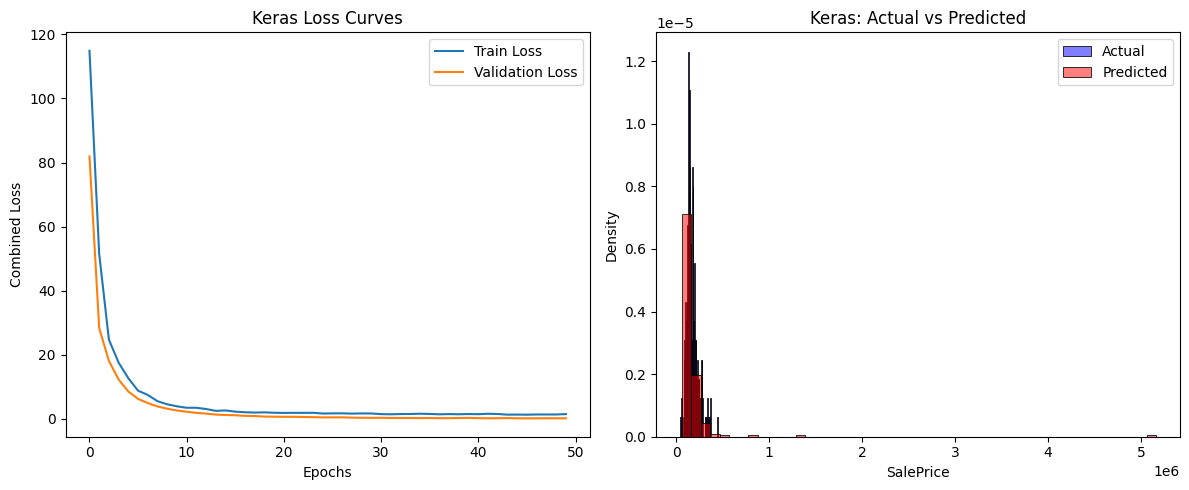

In [10]:
# Predict on validation set
y_val_pred_log = model_keras.predict(X_val_scaled).flatten()
print("Any NaNs in Keras predictions?", np.any(np.isnan(y_val_pred_log)))

# Convert back to original scale
y_val_pred = np.exp(y_val_pred_log)
y_val_actual = np.exp(y_val)  
rmse_keras = np.sqrt(mean_squared_error(y_val_actual, y_val_pred))
print('Keras Validation RMSE:', rmse_keras)

# Save test predictions
test_df_proc = fill_missing_values(test_df.copy())
test_ids = test_df_proc['Id']
test_df_proc.drop('Id', axis=1, inplace=True)
test_df_proc = pd.get_dummies(test_df_proc, drop_first=True)
test_df_proc = test_df_proc.reindex(columns=X.columns, fill_value=0)
test_scaled = scaler.transform(test_df_proc)

preds_test_log = model_keras.predict(test_scaled).flatten()
preds_test = np.exp(preds_test_log)

predictions_keras = pd.DataFrame({'ID': test_ids, 'SALEPRICE': preds_test})
predictions_keras.to_csv('predictions_keras_KL_v2.csv', index=False)
print('Keras predictions saved to predictions_keras_KL_v2.csv')

# Plot Keras loss curves and distribution
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_keras.history['loss'], label='Train Loss')
plt.plot(history_keras.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Combined Loss')
plt.title('Keras Loss Curves')
plt.legend()

plt.subplot(1,2,2)
sns.histplot(y_val_actual, bins=50, color='blue', alpha=0.5, stat='density', label='Actual')
sns.histplot(y_val_pred, bins=50, color='red', alpha=0.5, stat='density', label='Predicted')
plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.title('Keras: Actual vs Predicted')
plt.legend()
plt.tight_layout()
plt.show()

## 3. PyTorch Implementation

Build and train the PyTorch model. Note: we define the device before creating the model.

In [11]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [12]:
class HousePriceNetTorch(nn.Module):
    def __init__(self, input_dim):
        super(HousePriceNetTorch, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

input_dim_pt = X_train_scaled.shape[1]
model_torch = HousePriceNetTorch(input_dim_pt).to(device)
print(model_torch)

HousePriceNetTorch(
  (fc1): Linear(in_features=5, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)


In [13]:
def soft_histogram_torch(x, bin_centers, sigma):
    x = x.view(-1, 1)
    bin_centers = bin_centers.view(1, -1)
    diff = x - bin_centers
    soft_counts = torch.exp(- (diff ** 2) / (2 * sigma ** 2))
    hist = torch.sum(soft_counts, dim=0)
    hist = hist / torch.sum(hist)
    return hist

def kl_divergence_loss_torch(y_true, y_pred, num_bins=50, sigma=1.0):
    min_val = torch.min(y_true)
    max_val = torch.max(y_true)
    bin_centers = torch.linspace(min_val, max_val, steps=num_bins, device=y_true.device)
    hist_true = soft_histogram_torch(y_true, bin_centers, sigma)
    hist_pred = soft_histogram_torch(y_pred, bin_centers, sigma)
    epsilon = 1e-6
    hist_true = torch.clamp(hist_true, min=epsilon, max=1.0)
    hist_pred = torch.clamp(hist_pred, min=epsilon, max=1.0)
    kl = torch.sum(hist_true * torch.log(hist_true / hist_pred))
    return kl

def combined_loss_torch(y_true, y_pred, alpha=0.001):
    mse = torch.mean((y_true - y_pred) ** 2)
    kl = kl_divergence_loss_torch(y_true, y_pred, num_bins=50, sigma=1.0)
    return mse + alpha * kl

# Print a test KL loss value (optional, for debugging)
# print(kl_divergence_loss_torch(y_train_tensor, model_torch(X_train_tensor), num_bins=50, sigma=1.0))

In [14]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1).to(device)

optimizer_torch = optim.Adam(model_torch.parameters(), lr=0.001)
num_epochs_pt = 50
train_losses_pt = []
val_losses_pt = []

for epoch in range(num_epochs_pt):
    model_torch.train()
    optimizer_torch.zero_grad()
    outputs = model_torch(X_train_tensor)
    loss = combined_loss_torch(y_train_tensor, outputs, alpha=0.001)
    loss.backward()
    optimizer_torch.step()
    train_losses_pt.append(loss.item())
    
    model_torch.eval()
    with torch.no_grad():
        val_outputs = model_torch(X_val_tensor)
        val_loss = combined_loss_torch(y_val_tensor, val_outputs, alpha=0.001)
        val_losses_pt.append(val_loss.item())
    
    if (epoch+1) % 10 == 0:
        rmse_val = np.sqrt(mean_squared_error(y_val_tensor.cpu().numpy(), val_outputs.cpu().numpy()))
        print(f"Epoch {epoch+1}/{num_epochs_pt}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val RMSE: {rmse_val:.4f}")

Epoch 10/50, Train Loss: 128.4186, Val Loss: 126.0565, Val RMSE: 11.2272
Epoch 20/50, Train Loss: 107.6408, Val Loss: 105.7836, Val RMSE: 10.2848
Epoch 30/50, Train Loss: 81.3470, Val Loss: 80.3982, Val RMSE: 8.9664
Epoch 40/50, Train Loss: 54.2101, Val Loss: 53.1025, Val RMSE: 7.2871
Epoch 50/50, Train Loss: 32.2498, Val Loss: 30.4398, Val RMSE: 5.5172


Any NaNs in PyTorch predictions? False
PyTorch Validation RMSE: 22776149.699082326
PyTorch predictions saved to predictions_pytorch_KL_v2.csv


/tmp/ipykernel_2507/3179406045.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_2507/3179406045.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

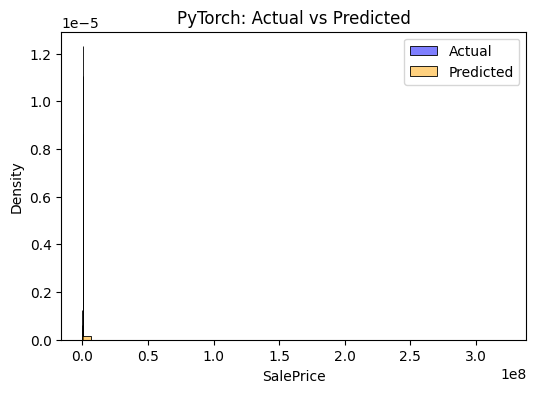

In [15]:
model_torch.eval()
with torch.no_grad():
    val_preds_pt_log = model_torch(X_val_tensor).cpu().numpy().flatten()

print("Any NaNs in PyTorch predictions?", np.any(np.isnan(val_preds_pt_log)))

# Convert predictions back to original scale
val_preds_pt = np.exp(val_preds_pt_log)
y_val_actual_pt = np.exp(y_val_tensor.cpu().numpy().flatten())
rmse_torch = np.sqrt(mean_squared_error(y_val_actual_pt, val_preds_pt))
print('PyTorch Validation RMSE:', rmse_torch)

# Save test predictions
test_df_proc = fill_missing_values(test_df.copy())
test_ids = test_df_proc['Id']
test_df_proc.drop('Id', axis=1, inplace=True)
test_df_proc = pd.get_dummies(test_df_proc, drop_first=True)
test_df_proc = test_df_proc.reindex(columns=X.columns, fill_value=0)
test_scaled = scaler.transform(test_df_proc)
test_tensor = torch.tensor(test_scaled, dtype=torch.float32).to(device)

model_torch.eval()
with torch.no_grad():
    test_preds_pt_log = model_torch(test_tensor).cpu().numpy().flatten()

test_preds_pt = np.exp(test_preds_pt_log)
predictions_torch = pd.DataFrame({'ID': test_ids, 'SALEPRICE': test_preds_pt})
predictions_torch.to_csv('predictions_pytorch_KL_v2.csv', index=False)
print('PyTorch predictions saved to predictions_pytorch_KL_v2.csv')

# Plot PyTorch distribution
plt.figure(figsize=(6,4))
sns.histplot(y_val_actual_pt, bins=50, color='blue', alpha=0.5, stat='density', label='Actual')
sns.histplot(val_preds_pt, bins=50, color='orange', alpha=0.5, stat='density', label='Predicted')
plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.title('PyTorch: Actual vs Predicted')
plt.legend()
plt.show()

## 4. JAX (Flax & Optax) Implementation

Build and train the model using JAX/Flax with a combined loss function.

In [16]:
class HousePriceNetJAX(nn_flax.Module):
    dropout_rate: float = 0.2
    
    @nn_flax.compact
    def __call__(self, x, training):
        x = nn_flax.Dense(128)(x)
        x = nn_flax.relu(x)
        x = nn_flax.Dropout(rate=self.dropout_rate)(x, deterministic=not training)
        x = nn_flax.Dense(64)(x)
        x = nn_flax.relu(x)
        x = nn_flax.Dropout(rate=self.dropout_rate)(x, deterministic=not training)
        x = nn_flax.Dense(1)(x)
        return x

model_jax = HousePriceNetJAX()
rng_jax = jax.random.PRNGKey(0)
dummy_input = jnp.ones((X_train_scaled.shape[0], X_train_scaled.shape[1]))
params_jax = model_jax.init(rng_jax, dummy_input, training=True)['params']
print('JAX model parameters initialized.')

JAX model parameters initialized.


In [17]:
class TrainState(train_state.TrainState):
    pass

def soft_histogram_jax(x, bin_centers, sigma):
    x = jnp.reshape(x, (-1, 1))
    diff = x - bin_centers
    soft_counts = jnp.exp(- (diff ** 2) / (2 * sigma ** 2))
    hist = jnp.sum(soft_counts, axis=0)
    hist = hist / jnp.sum(hist)
    return hist

def kl_divergence_loss_jax(params, batch, rng, training, num_bins=50, sigma=1.0):
    inputs, targets = batch
    preds = model_jax.apply({'params': params}, inputs, training=training, rngs={'dropout': rng})
    min_val = jnp.min(targets)
    max_val = jnp.max(targets)
    bin_centers = jnp.linspace(min_val, max_val, num_bins)
    hist_true = soft_histogram_jax(jnp.ravel(targets), bin_centers, sigma)
    hist_pred = soft_histogram_jax(jnp.ravel(preds), bin_centers, sigma)
    epsilon = 1e-6
    hist_true = jnp.clip(hist_true, epsilon, 1.0)
    hist_pred = jnp.clip(hist_pred, epsilon, 1.0)
    kl = jnp.sum(hist_true * jnp.log(hist_true / hist_pred))
    return kl

def mse_loss_jax(params, batch, rng, training):
    inputs, targets = batch
    preds = model_jax.apply({'params': params}, inputs, training=training, rngs={'dropout': rng})
    return jnp.mean((preds - targets) ** 2)

def combined_loss_jax(params, batch, rng, training, alpha=0.001):
    mse = mse_loss_jax(params, batch, rng, training)
    kl = kl_divergence_loss_jax(params, batch, rng, training, num_bins=50, sigma=1.0)
    return mse + alpha * kl

learning_rate = 0.001
tx = optax.adam(learning_rate)
state_jax = TrainState.create(apply_fn=model_jax.apply, params=params_jax, tx=tx)
print('JAX training state created.')

JAX training state created.


In [18]:
@jax.jit
def train_step_jax(state, batch, rng):
    grad_fn = jax.value_and_grad(combined_loss_jax)
    loss, grads = grad_fn(state.params, batch, rng, True, 0.001)
    state = state.apply_gradients(grads=grads)
    return state, loss

@jax.jit
def eval_step_jax(params, batch, rng):
    return combined_loss_jax(params, batch, rng, False, 0.001)

num_epochs_jax = 50
train_losses_jax = []
val_losses_jax = []

for epoch in range(num_epochs_jax):
    rng_jax, step_rng = jax.random.split(rng_jax)
    batch_train = (jnp.array(X_train_scaled), jnp.array(y_train.values).reshape(-1,1))
    state_jax, loss = train_step_jax(state_jax, batch_train, step_rng)
    train_losses_jax.append(loss.item())
    
    batch_val = (jnp.array(X_val_scaled), jnp.array(y_val.values).reshape(-1,1))
    val_loss = eval_step_jax(state_jax.params, batch_val, step_rng)
    val_losses_jax.append(val_loss.item())
    
    if (epoch + 1) % 10 == 0:
        preds_val_log = model_jax.apply({'params': state_jax.params}, jnp.array(X_val_scaled), training=False, rngs={'dropout': step_rng})
        rmse_jax = jnp.sqrt(jnp.mean((jnp.exp(preds_val_log) - jnp.exp(jnp.array(y_val.values).reshape(-1,1))) ** 2))
        print(f"Epoch {epoch+1}/{num_epochs_jax} - Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val RMSE: {rmse_jax.item():.4f}")

Epoch 10/50 - Train Loss: 106.6536, Val Loss: 102.8026, Val RMSE: 184558.9375
Epoch 20/50 - Train Loss: 72.7857, Val Loss: 70.1797, Val RMSE: 183799.4375
Epoch 30/50 - Train Loss: 46.0348, Val Loss: 43.8628, Val RMSE: 18426294.0000
Epoch 40/50 - Train Loss: 33.0997, Val Loss: 31.4605, Val RMSE: 5643284480.0000
Epoch 50/50 - Train Loss: 30.3144, Val Loss: 27.1049, Val RMSE: 85150531584.0000


Any NaNs in JAX predictions? False
JAX Validation RMSE: 85150543053.09625


/tmp/ipykernel_2507/3179406045.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_2507/3179406045.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

JAX predictions saved to predictions_jax_KL_v2.csv


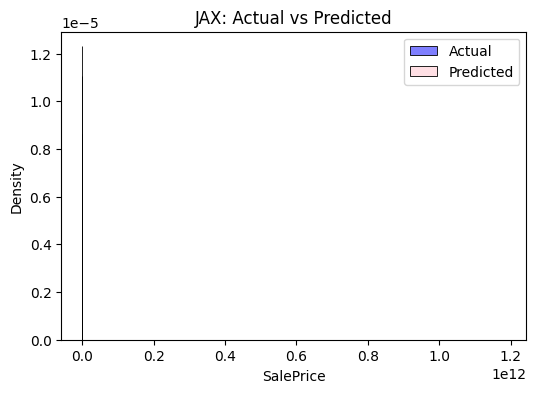

In [19]:
preds_val_log = model_jax.apply({'params': state_jax.params}, jnp.array(X_val_scaled), training=False, rngs={'dropout': rng_jax})
preds_val_log = np.array(preds_val_log).flatten()
print("Any NaNs in JAX predictions?", np.any(np.isnan(preds_val_log)))

# Convert predictions back to original scale
y_val_pred_jax = np.exp(preds_val_log)
y_val_actual_jax = np.exp(y_val.values.flatten())
rmse_jax_final = np.sqrt(mean_squared_error(y_val_actual_jax, y_val_pred_jax))
print('JAX Validation RMSE:', rmse_jax_final)

# Save JAX test predictions
test_df_proc = fill_missing_values(test_df.copy())
test_ids = test_df_proc['Id']
test_df_proc.drop('Id', axis=1, inplace=True)
test_df_proc = pd.get_dummies(test_df_proc, drop_first=True)
test_df_proc = test_df_proc.reindex(columns=X.columns, fill_value=0)
test_scaled = scaler.transform(test_df_proc)
test_jax = jnp.array(test_scaled)

preds_test_log = model_jax.apply({'params': state_jax.params}, test_jax, training=False, rngs={'dropout': rng_jax})
preds_test_log = np.array(preds_test_log).flatten()
preds_test_jax = np.exp(preds_test_log)

predictions_jax = pd.DataFrame({'ID': test_ids, 'SALEPRICE': preds_test_jax})
predictions_jax.to_csv('predictions_jax_KL_v2.csv', index=False)
print('JAX predictions saved to predictions_jax_KL_v2.csv')

# Plot JAX distribution
plt.figure(figsize=(6,4))
sns.histplot(y_val_actual_jax, bins=50, color='blue', alpha=0.5, stat='density', label='Actual')
sns.histplot(y_val_pred_jax, bins=50, color='pink', alpha=0.5, stat='density', label='Predicted')
plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.title('JAX: Actual vs Predicted')
plt.legend()
plt.show()

## 5. Combined Summary and Comparison

This section prints the RMSE values for each framework and plots combined loss curves and distribution histograms.

Keras RMSE: 360599.8884997685
PyTorch RMSE: 22776149.699082326
JAX RMSE: 85150543053.09625


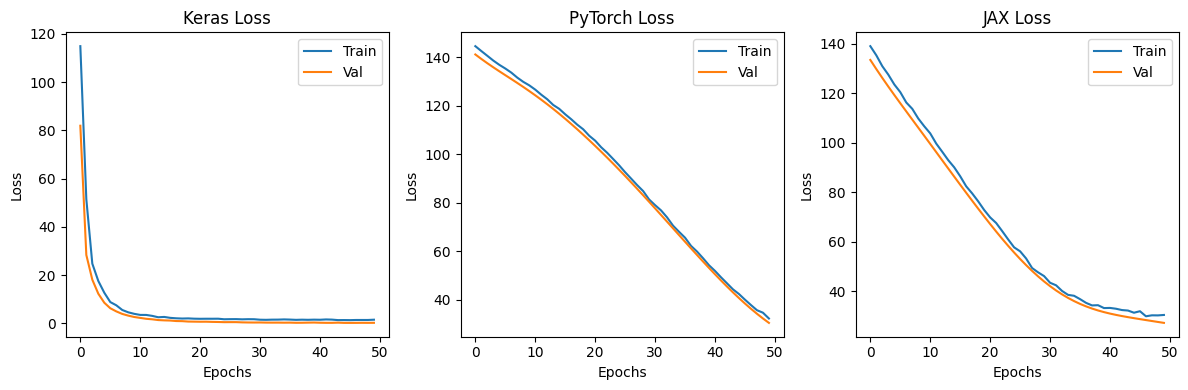

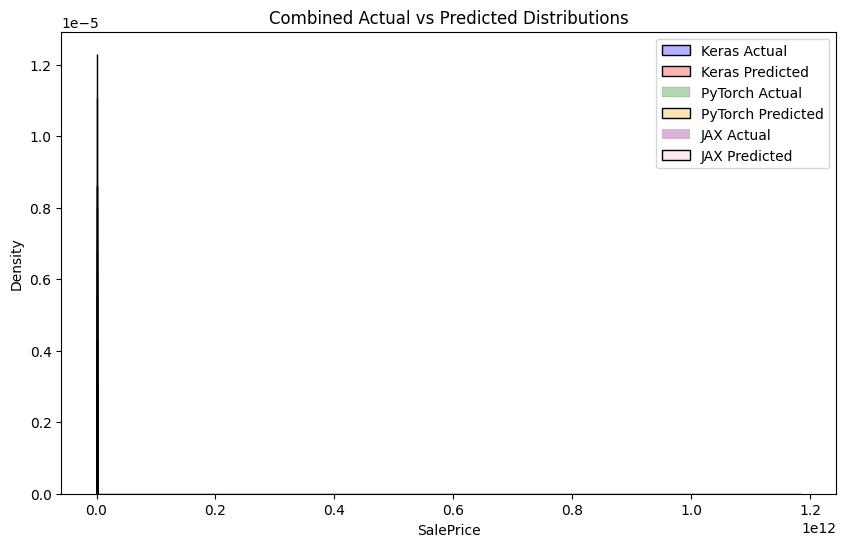

In [20]:
# Print summary RMSE values
print("Keras RMSE:", rmse_keras)
print("PyTorch RMSE:", rmse_torch)
print("JAX RMSE:", rmse_jax_final)

# Plot combined loss curves (side-by-side if available)
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(history_keras.history['loss'], label='Train')
plt.plot(history_keras.history['val_loss'], label='Val')
plt.title('Keras Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,3,2)
plt.plot(train_losses_pt, label='Train')
plt.plot(val_losses_pt, label='Val')
plt.title('PyTorch Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,3,3)
plt.plot(train_losses_jax, label='Train')
plt.plot(val_losses_jax, label='Val')
plt.title('JAX Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Combined distribution histogram overlay for validation set (using Keras, PyTorch, and JAX results)
plt.figure(figsize=(10,6))
sns.histplot(y_val_actual, bins=50, color='blue', alpha=0.3, stat='density', label='Keras Actual')
sns.histplot(np.exp(y_val_pred_log), bins=50, color='red', alpha=0.3, stat='density', label='Keras Predicted')

sns.histplot(y_val_actual_pt, bins=50, color='green', alpha=0.3, stat='density', label='PyTorch Actual')
sns.histplot(val_preds_pt, bins=50, color='orange', alpha=0.3, stat='density', label='PyTorch Predicted')

sns.histplot(y_val_actual_jax, bins=50, color='purple', alpha=0.3, stat='density', label='JAX Actual')
sns.histplot(y_val_pred_jax, bins=50, color='pink', alpha=0.3, stat='density', label='JAX Predicted')

plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.title('Combined Actual vs Predicted Distributions')
plt.legend()
plt.show()